# Exploring Reddit Comment Data for User Community Reccomendation

## Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

FIGWIDTH = 8
FIGHEIGHT = 8
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGHEIGHT]

In [4]:
COMMENTS = '../data/out/comments.csv'
COMMENTS_COMMENTS = '../data/out/comments_comments.csv'
USERS_COMMENTS = '../data/out/users_comments.csv'

comments = {}
comments_to_subreddit = {}
with open(COMMENTS) as f:
    for l in f.readlines():
        c, s, t, k = l.split(',')
        comments[c] = {
            'subreddit': s,
            'timestamp': int(t),
            'karma': int(k.strip())
        }
        comments_to_subreddit[c] = s

comment_parent_map = {}
with open(COMMENTS_COMMENTS) as f:
    for l in f.readlines():
        p, c = l.split(',')
        comment_parent_map[c.strip()] = p

comment_user_map = {}
user_subreddit_data = []
with open(USERS_COMMENTS) as f:
    for l in f.readlines():
        u, c = l.split(',')
        c = c.strip()
        comment_user_map[c] = u
        user_subreddit_data.append({
            'user': u,
            'subreddit': comments_to_subreddit[c]
        })
user_subreddits = pd.DataFrame(user_subreddit_data, columns=['user', 'subreddit'])

## Comment Chains

Like many other social platforms, Reddit's comment representation is a tree structure where separate replies to a comment are branches. We can think of conversation in one of these trees as a comment chain, that is, a set of comments where each one (apart from the first comment) is a reply to one preceding it. We will investigate the typical size, shape and diversity of users in each of these chains:

### Data Structure Setup

In [5]:
comment_chains = {}
for c in comment_parent_map:
    root = c
    chain = set()
    users = []
    while root in comment_parent_map:
        chain.add(root)
        root = comment_parent_map[root]
    if root in comment_chains:
        comment_chains[root].update(chain)
    else:
        comment_chains[root] = chain
user_chains = pd.Series([[comment_user_map[c] for c in cset] for cset in comment_chains.values()])
print('Number of comment chains: {}'.format(len(comment_chains)))

Number of comment chains: 961293


### Comment Chain Lengths

So, in total we have 942,558 comment chain in our data. Let's summarize them:

In [6]:
chain_lengths = pd.Series([len(chain) for chain in comment_chains.values()])
chain_lengths.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,961293.0,2.809508,6.092239,1.0,1.0,1.0,3.0,933.0


The data seems to be very compact around small numbers such as 1 and 2 with large outliers, we will further investigatge the distribution:

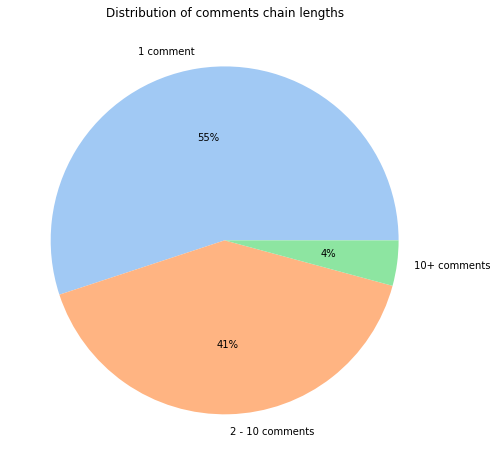

In [7]:
def chain_length_binner(x):
    if x == 1:
        return '1 comment'
    elif 1 < x < 10:
        return '2 - 10 comments'
    return '10+ comments'

chain_length_bins = pd.Series([chain_length_binner(cl) for cl in chain_lengths]).value_counts(normalize=True)
colors = sns.color_palette('pastel')[0:5]
plt.pie(chain_length_bins, labels=chain_length_bins.index, colors = colors, autopct='%.0f%%')
plt.title('Distribution of comments chain lengths')
plt.show()

From the above chart, we can see that the majority of comments do not actually belong to a comment chain. This means that the comment was posted and no-one replied. These data are likely not very useful in generating meaningful metrics for recommendation based on user comment interactions.

However, 45% of the comment data are part of chains with 41% being 'small' chains of only 2 - 10 comments and the other 4% being long chains with over 10 comments. We can examine the distributions of both of these groups:

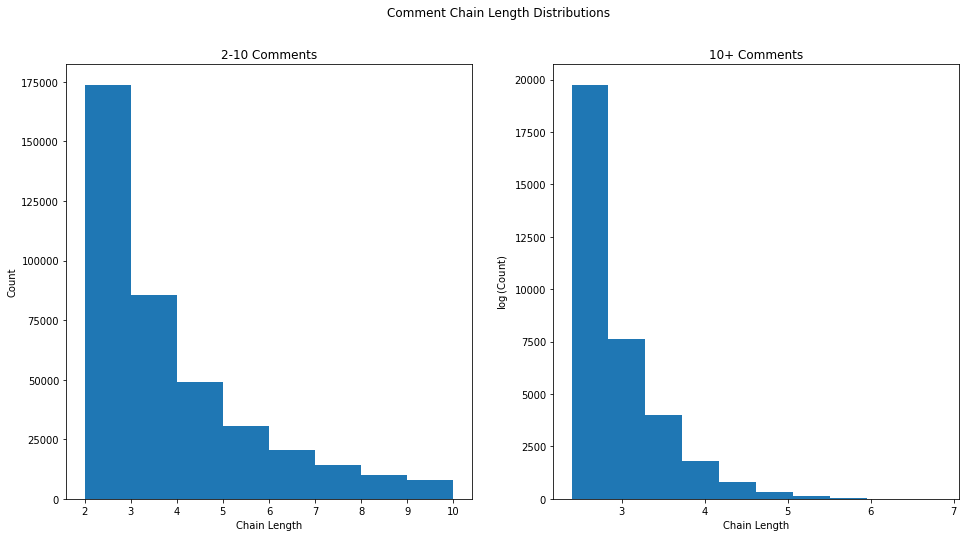

In [8]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(FIGWIDTH * len(ax))
fig.set_figheight(FIGHEIGHT)

ax[0].hist([cl for cl in chain_lengths if 1 < cl < 10], bins=range(2, 11));
ax[1].hist([np.log(cl) for cl in chain_lengths if cl > 10]);
fig.suptitle('Comment Chain Length Distributions');
ax[0].set_title('2-10 Comments');
ax[0].set_xlabel('Chain Length');
ax[0].set_ylabel('Count');
ax[1].set_title('10+ Comments');
ax[1].set_xlabel('Chain Length');
ax[1].set_ylabel('$\log$(Count)');

As we might expect, we generally have less chains of longer lengths. In short, there are mostly smaller chains in the data but the distribution is heavily right-skewed due to some very long chains.

### Users in Chains

Now we will look at some data such as the number of users in each chain and the number of times users tend to interact in a chain.

First, we will focus on the number of unique users per chain:

In [9]:
users_in_chain = pd.Series([len(set(users)) for users in user_chains])
users_in_chain.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,961293.0,2.260751,4.081731,1.0,1.0,1.0,2.0,619.0


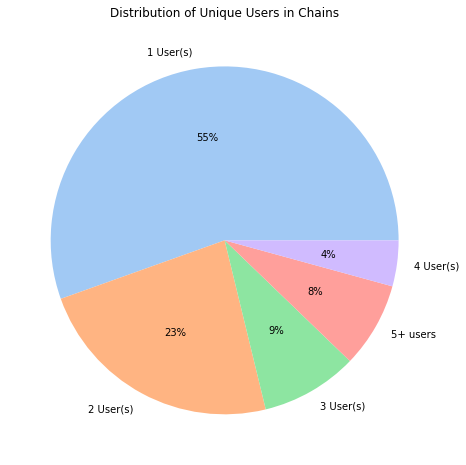

In [10]:
def unique_users_binner(x):
    if x < 5:
        return '{} User(s)'.format(x)
    return '5+ users'

unique_users_bins = pd.Series([unique_users_binner(u) for u in users_in_chain]).value_counts(normalize=True)
colors = sns.color_palette('pastel')[0:5]
plt.pie(unique_users_bins, labels=unique_users_bins.index, colors = colors, autopct='%.0f%%')
plt.title('Distribution of Unique Users in Chains')
plt.show()

Next, we look at the ratio between the number of unique users in a chain and the total number of comments in that chain. This tells us how unique the set of users particpating in a chain is. Smaller ratios means there is less diversity.

In [11]:
users_per_chain_ratio = users_in_chain / chain_lengths
users_per_chain_ratio.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,961293.0,0.937237,0.153587,0.016129,1.0,1.0,1.0,1.0


We can see that the chains are generally quite diverse as, on average, the number of unique users is very close to the total number of comments. However, because we are including chains of length one which the ration is guarenteed to be 1.0 for, this value is quite skewed. We remove those and try again:

In [12]:
user_chain_ratio_df = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
user_chain_ratio_df_index = []
for i in range(1, 11):
    non_singleton_idx = users_in_chain > i
    users_per_non_singleton_chain_ratio = users_in_chain[non_singleton_idx] / chain_lengths[non_singleton_idx]
    user_chain_ratio_df = user_chain_ratio_df.append(users_per_non_singleton_chain_ratio.describe().to_frame().T)
    user_chain_ratio_df_index.append('More than {} unique users in chain'.format(i))
user_chain_ratio_df.index = user_chain_ratio_df_index
user_chain_ratio_df

,count,mean,std,min,25%,50%,75%,max
More than 1 unique users in chain,428186.0,0.863724,0.202046,0.016129,0.727273,1.000000,1.000000,1.0
More than 2 unique users in chain,203798.0,0.828508,0.201938,0.016129,0.714286,0.888889,1.000000,1.0
More than 3 unique users in chain,117313.0,0.810526,0.196666,0.016129,0.666667,0.833333,1.000000,1.0
More than 4 unique users in chain,76377.0,0.799899,0.190595,0.016129,0.666667,0.833333,1.000000,1.0
More than 5 unique users in chain,54273.0,0.792572,0.185698,0.016129,0.666667,0.833333,1.000000,1.0
More than 6 unique users in chain,40719.0,0.787656,0.181037,0.073684,0.666667,0.818182,0.923077,1.0
More than 7 unique users in chain,32033.0,0.784463,0.176394,0.085366,0.666667,0.812500,0.916667,1.0
More than 8 unique users in chain,25871.0,0.781434,0.172553,0.085366,0.666667,0.812500,0.916667,1.0
More than 9 unique users in chain,21444.0,0.778778,0.169791,0.085366,0.666667,0.800000,0.916667,1.0
More than 10 unique users in chain,18123.0,0.777116,0.166389,0.085366,0.675000,0.800000,0.916667,1.0


This is more indicative of the data we wanted to see. Now, as we move towards larger and larger chains, the average ratio of unique users seems to plataeu at ~0.78.

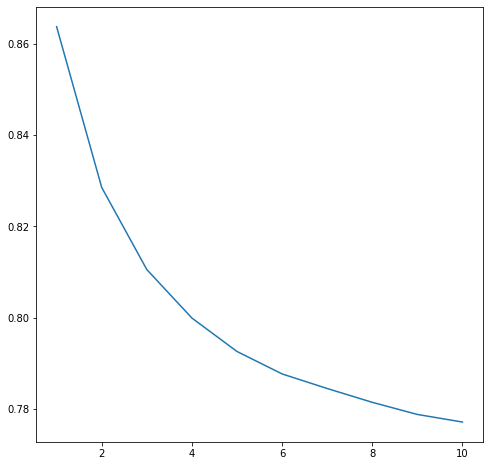

In [13]:
plt.plot(range(1, 11), user_chain_ratio_df['mean']);

### Karma in chains

Finally within chains, we will examine 'karma' which essentially measures how well recieved a comment is. The more negative the value, the more disliked it was and more positive the value, the more liked it was. We want to compute some karma metrics across chains to try and determine naively what kind of chain it may be.

In [14]:
# TODO: Karma EDA

## User interactions per Subreddit

Now we look into user interactions by subreddits. First, let us look at some statistics about users in subreddits:

In [15]:
user_sub_size = user_subreddits.groupby(['user', 'subreddit']).size()

In [16]:
user_sub_size.describe().to_frame()

,0
count,1.139074e+06
mean,4.127405e+00
std,1.380067e+01
min,1.000000e+00
25%,1.000000e+00
50%,2.000000e+00
75%,3.000000e+00
max,6.085000e+03


In [17]:
cmts = pd.read_csv('../data/out/comments.csv')
cmts_cmts = pd.read_csv('../data/out/comments_comments.csv')
users = pd.read_csv('../data/out/users.csv')
users_cmts = pd.read_csv('../data/out/users_comments.csv')

In [19]:

users_reddits = users_cmts.merge(cmts.rename({'c17frng':'c17frnf'}, axis=1), on='c17frnf', how='left')
users_reddits.head()

,_silentheartsong,c17frnf,Music,1291161600,-5
0,product19,c17frng,IAmA,1291161601,8
1,RegularFreddieWilson,c17frnh,pics,1291161601,7
2,superdarkness,c17frnk,funny,1291161605,2
3,dockmarlin,c17frnl,cats,1291161606,1
4,snotrokit,c17frnm,pics,1291161606,19


Here, we find the subreddits with the most unique users:

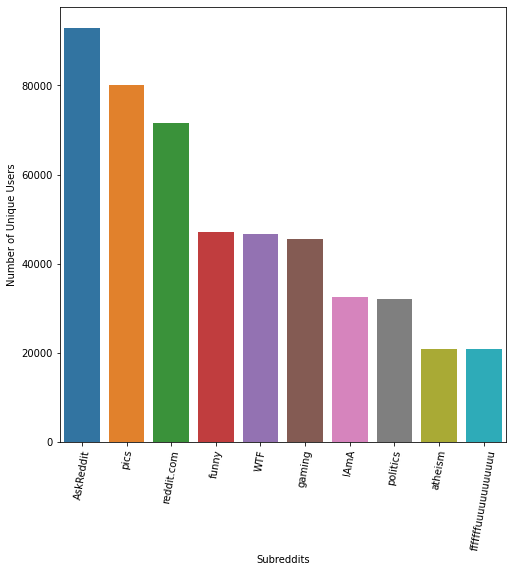

In [20]:

df = users_reddits.groupby(by='Music').nunique().rename({'_silentheartsong':'count'}, axis=1)[['count']].reset_index().rename({'Music':'subreddit'})
top_10_subs = df.sort_values('count', ascending=False).head(10)


sns.barplot(data=top_10_subs, x="Music", y="count")
plt.xticks(rotation=80)
# plt.title('Top 10 Subreddits with Unique Users')
plt.xlabel('Subreddits')
plt.ylabel('Number of Unique Users')
plt.show()

We can see that the most popular subreddit by far is 'AskReddit', followed by subreddits like 'pics', 'reddit.com', and 'funny'. This seems to make sense, as more users would be subscribed to broader subreddits and those related to Reddit itself. 

Next, we look into the distribution of the number of comments made by users:

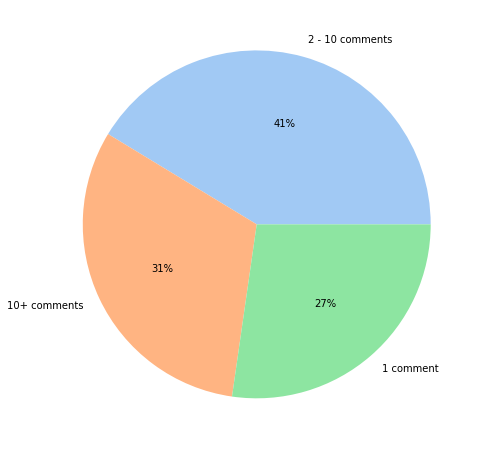

In [21]:
users_cmt_cnt = users_cmts.groupby('_silentheartsong').nunique().reset_index().rename({'_silentheartsong':'usernames', 'c17frnf':'num_cmts'}, axis=1).sort_values('num_cmts', ascending=False)

def bin(x):
    if x == 1:
        return '1 comment'
    elif 1 < x < 11:
        return '2 - 10 comments'
    elif 11 <= x:
        return '10+ comments'

users_cmt_cnt['range'] = users_cmt_cnt['num_cmts'].apply(bin)
simp = users_cmt_cnt['range'].value_counts(normalize=True).to_frame().reset_index()

data = simp['range']
labels = simp['index']

colors = sns.color_palette('pastel')[0:5]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
# plt.title('Distribution of comments made by Users')
plt.show()

What we see is that a bit over a quarter of users have made only 1 comment, 41% of users have made between 2 and 10 comments, and 31% of people have made more than 10 comments.

## Karma

Earlier we looked into Karma in comment chains. As we have defined, 'karma' essentially measures how well recieved a comment is. The more negative the value, the more disliked it was and more positive the value, the more liked it was. Now, we aim to look a bit more deeply into karma across various metrics.

In [23]:
comments = pd.read_csv('../data/out/comments.csv', header = None)
users_comments = pd.read_csv('../data/out/users_comments.csv', header = None)
comments.columns = ['cid','subreddit', 'created_utc', 'karma']
users_comments.columns = ['author', 'cid']
# join comments and users_comments tables
cuc = pd.merge(comments, users_comments, on='cid')

### Distribution of Karma by Author/User

As mentioned above, karma is calculated per comment. A user's total karma is then the sum of the karma of all of their individual comments and posts. First, we look to see the distribution of karma by user.

In [24]:
karma_by_author = pd.DataFrame(cuc.groupby('author')['karma'].sum()).reset_index()
karma_by_author = karma_by_author.sort_values('karma')
karma_by_author

,author,karma
24069,FastOCR18,-3187
133478,ginmhilleadh,-2713
172651,mikepunk,-1369
64772,SlowOCR_13,-980
159561,krakow057,-827
...,...,...
86469,ani625,16368
133025,ggggbabybabybaby,18172
55898,ProbablyHittingOnYou,18444
86101,andrewsmith1986,29956


From what we see here, users have karma values ranging between -3187 (lots of this users comments are poorly received) and 65,288 (this comments posts are generally very well received).

<AxesSubplot:xlabel='karma', ylabel='count of unique users'>

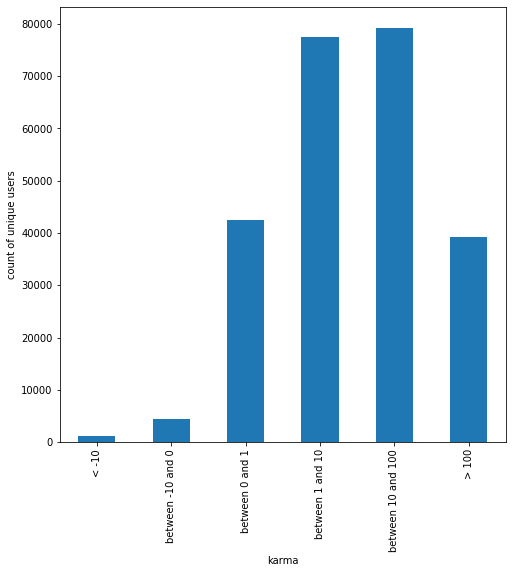

In [44]:
def bin(x):
    if x < -10:
        return '< -10'
    elif -10 <= x < 0:
        return 'between -10 and 0'
    elif 0 <= x <= 1:
        return 'between 0 and 1'
    elif 1 < x <= 10:
        return 'between 1 and 10'
    elif 10 < x <= 100:
        return 'between 10 and 100'
    else:
        return '> 100'

karma_by_author['bin'] = karma_by_author['karma'].apply(bin)
karma_by_author['bin'] = pd.Categorical(karma_by_author['bin'],
                                        ['< -10', 'between -10 and 0',
                                         'between 0 and 1', 'between 1 and 10',
                                         'between 10 and 100', '> 100'])

bins = karma_by_author.groupby('bin')['karma'].count()

bins.plot(kind = 'bar', xlabel = 'karma', ylabel = 'count of unique users')

What we see from this is that many users have between 1 and 100 karma, while very few users have negative karma at all.

### Average Karma for a Comment by Subreddit

Next, we will look at the average karma for comments by users. This will help us see how much karma on average a comment will get by user.

In [36]:
karma_by_author_avg = pd.DataFrame(cuc.groupby('author')['karma'].mean()).reset_index()
karma_by_author_avg.sort_values('karma')

,author,karma
98626,breeedeeer,-113.0
88733,asdffsd,-78.0
237371,wikimedia,-65.0
6316,AttackingHobo,-51.6
92768,beast_of_a_priest,-47.0
...,...,...
42575,Lovesnoveltyaccounts,1284.0
77,-captain-hindsight-,1293.0
71790,The_Joke_Explained,1596.0
85287,amativus,1738.0


From this dataframe above, we see that the average karma for a comment a user makes in our dataset is bounded between -113 on the lower end and 2232 on the upper end.

<AxesSubplot:xlabel='average karma', ylabel='count of unique users'>

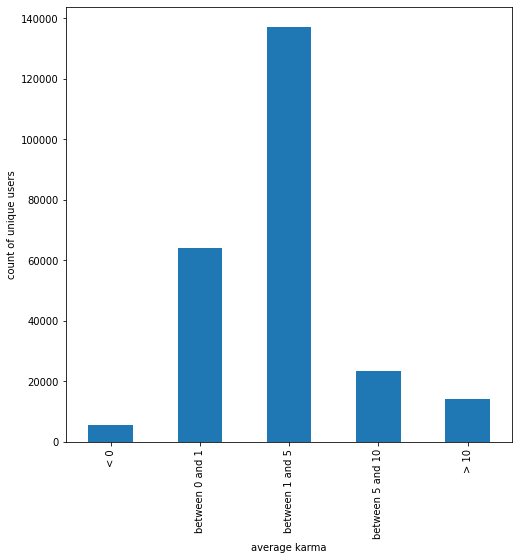

In [45]:
def bin(x):
    if x < 0:
        return '< 0'
    elif 0 <= x <= 1:
        return 'between 0 and 1'
    elif 1 < x <= 5:
        return 'between 1 and 5'
    elif 5 < x <= 10:
        return 'between 5 and 10'
    else:
        return '> 10'

karma_by_author_avg['bin'] = karma_by_author_avg['karma'].apply(bin)
karma_by_author_avg['bin'] = pd.Categorical(karma_by_author_avg['bin'],
                                        ['< 0', 'between 0 and 1',
                                         'between 1 and 5',
                                         'between 5 and 10', '> 10'])

bins = karma_by_author_avg.groupby('bin')['karma'].count()

bins.plot(kind = 'bar', xlabel = 'average karma', ylabel = 'count of unique users')

Clearly, most comments that users make get on average between 1 and 5 karma.

### Average Karma for a Comment by Subreddit

Next, we can take a look at the average karma for a comment  by Subreddit. This will help us see if most comments in subreddits have karma levels hovering between -1 and 1, or if maybe they differ significantly.

In [47]:
karma_by_subreddit = pd.DataFrame(cuc.groupby('subreddit')['karma'].mean()).reset_index()
karma_by_subreddit.sort_values('karma')

,subreddit,karma
355,CompulsiveDownvoters,-5.000000
2241,crybaby,-4.166667
2170,coke,-2.000000
1026,NaziHunting,-1.086957
1195,PornStars,-1.000000
...,...,...
3696,redditzine,12.000000
1624,VOTE4DICKOFTHEYEAR,12.104167
2405,ectalProlapse,14.000000
3719,republicans,23.000000


We can see that the average comment karma by subreddit in our dataset is between -5 and 27.61. Let's plot this data:

<AxesSubplot:xlabel='average karma', ylabel='count of unique subreddits'>

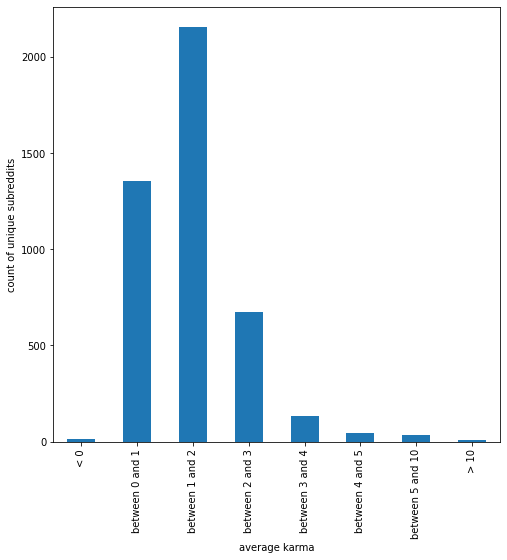

In [50]:
def bin(x):
    if x < 0:
        return '< 0'
    elif 0 <= x <= 1:
        return 'between 0 and 1'
    elif 1 < x <= 2:
        return 'between 1 and 2'
    elif 2 < x <= 3:
        return 'between 2 and 3'
    elif 3 < x <= 4:
        return 'between 3 and 4'
    elif 4 < x <= 5:
        return 'between 4 and 5'
    elif 5 < x <= 10:
        return 'between 5 and 10'
    else:
        return '> 10'

karma_by_subreddit['bin'] = karma_by_subreddit['karma'].apply(bin)
karma_by_subreddit['bin'] = pd.Categorical(karma_by_subreddit['bin'],
                                        ['< 0', 'between 0 and 1',
                                         'between 1 and 2', 'between 2 and 3',
                                         'between 3 and 4', 'between 4 and 5',
                                         'between 5 and 10', '> 10'])

bins = karma_by_subreddit.groupby('bin')['karma'].count()

bins.plot(kind = 'bar', xlabel = 'average karma', ylabel = 'count of unique subreddits')

As we can see, most of these subreddits have an average karma for comments in the subreddit between 0 and 3.

## Volume of comments against day of the Month

Finally, let us look at the volume of comments by day of the month they are posted on. Our dataset contains the date each comment is posted on in utc time. Let us convert this to a datetime so we can more easily pull dates from it:

In [52]:
comments.columns = ['comment_id', 
              'subreddit', 
              'timestamp', 
              'karma']
def convert_to_dt(timestamp):
    dt = datetime.fromtimestamp(timestamp)
    return dt

try:
    comments['timestamp'] = comments['timestamp'].apply(convert_to_dt)
except:
    pass

comments['year'] = pd.DatetimeIndex(comments['timestamp']).year
comments['month'] = pd.DatetimeIndex(comments['timestamp']).month
comments['day'] = pd.DatetimeIndex(comments['timestamp']).day
comments['hour'] = pd.DatetimeIndex(comments['timestamp']).hour
comments['weekday'] = pd.DatetimeIndex(comments['timestamp']).weekday
comments.head()

,comment_id,subreddit,timestamp,karma,year,month,day,hour,weekday
0,c17frnf,Music,2010-11-30 16:00:00,-5,2010,11,30,16,1
1,c17frng,IAmA,2010-11-30 16:00:01,8,2010,11,30,16,1
2,c17frnh,pics,2010-11-30 16:00:01,7,2010,11,30,16,1
3,c17frnk,funny,2010-11-30 16:00:05,2,2010,11,30,16,1
4,c17frnl,cats,2010-11-30 16:00:06,1,2010,11,30,16,1
...,...,...,...,...,...,...,...,...,...
4701415,c1b06fj,science,2010-12-31 15:59:57,0,2010,12,31,15,4
4701416,c1b06fk,australia,2010-12-31 15:59:57,2,2010,12,31,15,4
4701417,c1b06fm,gaming,2010-12-31 15:59:57,1,2010,12,31,15,4
4701418,c1b06fn,funny,2010-12-31 15:59:57,-3,2010,12,31,15,4


Let us look into what months our dataset consists of:

In [53]:
grouped = comments.groupby(['month', 'day']).count()
grouped

comment_id  subreddit  timestamp   karma    year    hour  weekday
month day                                                                   
11    30        63141      63141      63141   63141   63141   63141    63141
12    1        151284     151284     151284  151284  151284  151284   151284
      2        127638     127638     127638  127638  127638  127638   127638
      3        159309     159309     159309  159309  159309  159309   159309
      4        120771     120771     120771  120771  120771  120771   120771
      5        133489     133489     133489  133489  133489  133489   133489
      6        167630     167630     167630  167630  167630  167630   167630
      7        174313     174313     174313  174313  174313  174313   174313
      8        175478     175478     175478  175478  175478  175478   175478
      9        172127     172127     172127  172127  172127  172127   172127
      10       160426     160426     160426  160426  160426  160426   160426
      11       135179     135179     135179  135179  135179  135179   135179
      12       148638     148638     148638  148638  148638  148638   148638
      13       178487     178487     178487  178487  178487  178487   178487
      14       170594     170594     170594  170594  170594  170594   170594
      15       182470     182470     182470  182470  182470  182470   182470
      16       172948     172948     172948  172948  172948  172948   172948
      17       157330     157330     157330  157330  157330  157330   157330
      18       126930     126930     126930  126930  126930  126930   126930
      19       130086     130086     130086  130086  130086  130086   130086
      20       155943     155943     155943  155943  155943  155943   155943
      21       162464     162464     162464  162464  162464  162464   162464
      22       163575     163575     163575  163575  163575  163575   163575
      23       141843     141843     141843  141843  141843  141843   141843
      24       107482     107482     107482  107482  107482  107482   107482
      25       113165     113165     113165  113165  113165  113165   113165
      26       116168     116168     116168  116168  116168  116168   116168
      27       151338     151338     151338  151338  151338  151338   151338
      28       163108     163108     163108  163108  163108  163108   163108
      29       172834     172834     172834  172834  172834  172834   172834
      30       160374     160374     160374  160374  160374  160374   160374
      31        84858      84858      84858   84858   84858   84858    84858

We see that most of our data is in the month of December. As such, let us plot the volume of comments by day in the month of December to see what insights we can draw from it:

<BarContainer object of 31 artists>

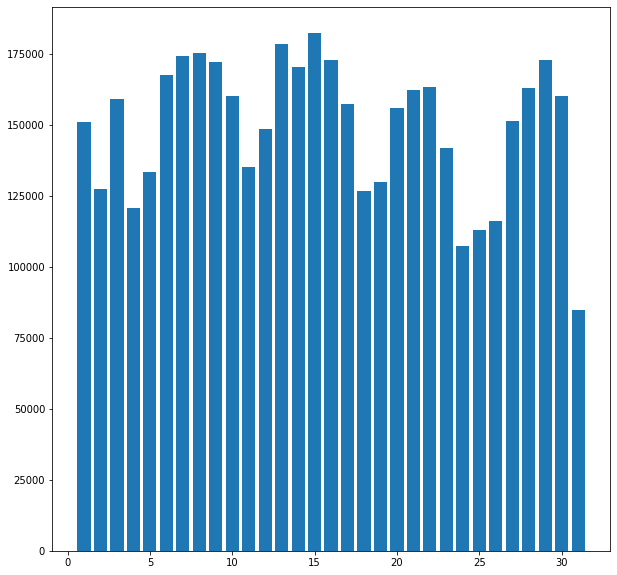

In [56]:
december = grouped[1:]['comment_id']
fig, axes = plt.subplots(figsize=(10, 10))
plt.bar(range(1, 32), december.values)

Clearly there does not seem to be much of a trend visible to us from this plot. It seems like the day of the month does not make a huge impact on the volume of comments posted that day.